### CITS4404 Practical Project

# Camo Worms - Evolutionary Algorithm

In [29]:
# imports
from camo_worms_utils import *
from random import shuffle

In [30]:
def get_cost(image, worm_idx: int, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    worm = clew[worm_idx]
    # ********************
    # internal
    
    # lets just say we want worms to be around 5 px wide
    # scale so that 5px => low score, lower or higher width => high score
    ideal = 10
    dist_from_ideal = np.abs(worm.width - ideal)

    internal_score = dist_from_ideal

    # ********************
    # group

    # lets get avg dist to other worms
    dists = []
    for i in range(len(clew)):
        if i is not worm_idx:
            euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
            # print(f"Worm centre ({worm.x}, {worm.y})")
            # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
            # print(f"Dist: {euclid_dist}")
            dists.append(euclid_dist)
    avg_dist = np.mean(dists)

    # option1
    # want worms spread out (add small constant to prevent divide by 0)
    # take min with 1 to keep on scale 0 to 1
    inversed = 1/(avg_dist+0.00001)
    # define as 0 for some ideal distance apart (should define it better than max(image.shape))
    # if avg_dist > 20:
    #     inversed = 0
    # # define as 1 for too far apart
    # if avg_dist > 20*1.05:
    #     inversed = 1
    group_score = inversed

    # option2
    # want worms shoulder to shoulder (this makes more sense?)
    # want the worm to be their size in distance away from other worms
    # ideal = worm.width*2
    # dist_from_ideal = np.abs(avg_dist - ideal)
    # group_score = dist_from_ideal
    # NOTE - we can do this better
    # would want to have average dist from each point in worm to other points in other worms
    # i.e. want a dist score for the start, middle, and end of worm and aggregate them
    # right now a worm could be 'size' distance away from centre point but still be overlapping the worm but score will be 0

    # want worms shoulder to shoulder
    # ********************
    # environment

    # we want worms to match mean colour underneath them
    colour_score = np.abs(worm.get_mean_colour_under(image) - worm.colour)
    enviro_score = colour_score

    # return total weighted and individual scores
    return (
        internal_score*w_internal + group_score*w_group + enviro_score*w_environment,
        internal_score*w_internal,
        group_score*w_group,
        enviro_score*w_environment
    )

In [31]:
def get_fittest(image, clew: list[Camo_Worm], top_n: int, w_internal: float=1.0, w_group: float=1.0, w_environment: float=1.0):
    scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    costs = [score[0] for score in scores]
    internal_scores = [score[1] for score in scores]
    group_scores = [score[2] for score in scores]
    enviro_scores = [score[3] for score in scores]
    sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])
    return (
        [worm for worm,cost in sorted_clew[:top_n]],
        np.mean(costs),
        np.mean(internal_scores),
        np.mean(group_scores),
        np.mean(enviro_scores)
    )

In [32]:
def mutate_worm(worm: Camo_Worm):
    
    new_x = worm.x + rng.uniform(-20, 20)
    new_y = worm.y + rng.uniform(-20, 20)


    new_r = worm.r
    new_theta = worm.theta
    new_deviation_r = worm.dr
    new_deviation_gamma = worm.dgamma

    # just doing width and colour
    new_width = (worm.width + rng.uniform(-1,1))
    
    new_colour = (worm.colour + rng.uniform(-1,1))
    new_colour = max( new_colour, 0 )
    new_colour = min( new_colour, 1 )

    return Camo_Worm(new_x, new_y, new_r, new_theta, new_deviation_r, new_deviation_gamma, new_width, new_colour)

def get_next_clew(fittest: list[Camo_Worm], size: int):
    # we will keep the parents and add new worms to size
    new_clew=fittest

    # shuffle for randomness
    shuffle(fittest)
    i = 0
    while len(new_clew) < size:
        reference_worm = fittest[i]
        # mutate and add to clew
        new_worm=mutate_worm(reference_worm)
        new_clew.append(new_worm)

    return new_clew

In [33]:
def train(image, mu: int, lmbda: int, num_epochs: int=100):
    # using algorithm like https://thomasweise.github.io/aitoa/aitoa.pdf#page=114&zoom=100,94,226
    # EA no recombination
    # mu is number of parents
    # lambda is number of offspring
    # total clew = mu + lambda
    clew = initialise_clew(mu+lmbda, image.shape, (40, 30, 1))

    print("Initial")
    observe_clew(clew, image)

    for i in range(num_epochs+1):
        # get fittest mu worms
        fittest, avg_cost, avg_internal, avg_group, avg_enviro = get_fittest(image, clew, mu, w_group=10)
        # get next clew of size mu + lambda
        clew = get_next_clew(fittest.copy(), size=mu+lmbda)
        if i%20==0:
            print(60*"*")
            print(f"Epoch: {i}")
            print(f"Fittest {len(fittest)} worms\n")
            print("Average Weighted Scores")
            print("-"*30)
            print("Internal:".ljust(20) + f"{avg_internal:.4f}")
            print("Group:".ljust(20) + f"{avg_group:.4f}")
            print("Environment:".ljust(20) + f"{avg_enviro:.4f}")
            print("-"*30)
            print("Total Cost:".ljust(20) + f"{avg_cost:.4f}")
            observe_clew(fittest, image)
            print("Next Clew")
            observe_clew(clew, image)
            print(f"Worm width: {clew[0].width}")

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


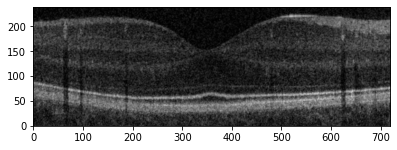

Initial


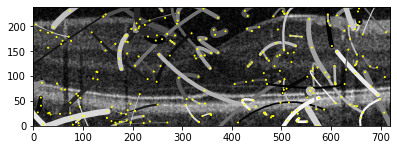

************************************************************
Epoch: 0
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           6.9657
Group:              0.0376
Environment:        0.3391
------------------------------
Total Cost:         7.3425


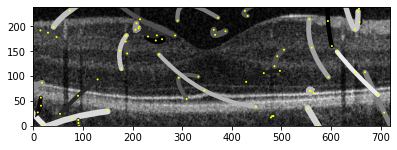

Next Clew


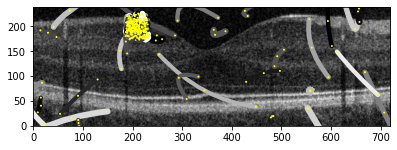

Worm width: 5.8873773173434145


C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

************************************************************
Epoch: 20
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           0.3413
Group:              0.3001
Environment:        0.2094
------------------------------
Total Cost:         0.8507


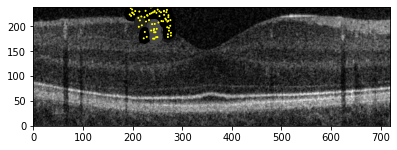

Next Clew


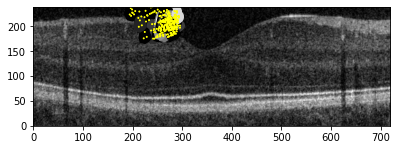

Worm width: 9.892892361320499


C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

************************************************************
Epoch: 40
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           0.3514
Group:              0.3019
Environment:        nan
------------------------------
Total Cost:         nan


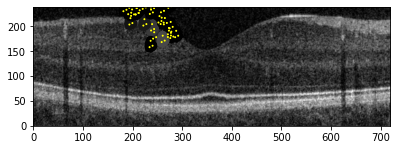

Next Clew


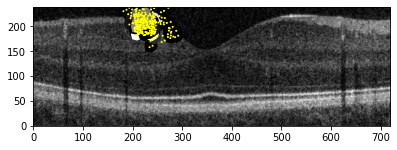

Worm width: 10.048037271224771


C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

************************************************************
Epoch: 60
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           0.3822
Group:              0.2455
Environment:        0.2171
------------------------------
Total Cost:         0.8448


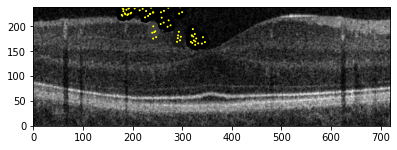

Next Clew


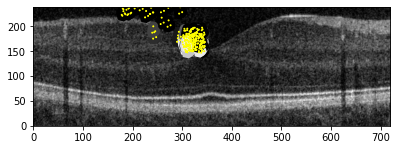

Worm width: 10.010644433719442


C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

************************************************************
Epoch: 80
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           0.3483
Group:              0.2478
Environment:        0.2183
------------------------------
Total Cost:         0.8144


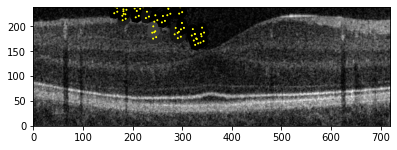

Next Clew


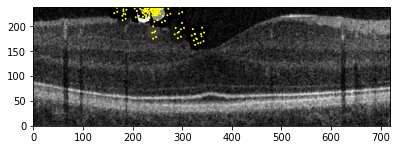

Worm width: 9.987167031372902


C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\evste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

************************************************************
Epoch: 100
Fittest 30 worms

Average Weighted Scores
------------------------------
Internal:           0.3744
Group:              0.2688
Environment:        nan
------------------------------
Total Cost:         nan


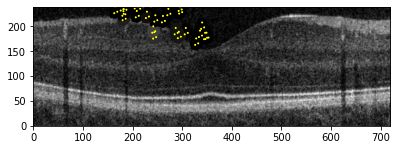

Next Clew


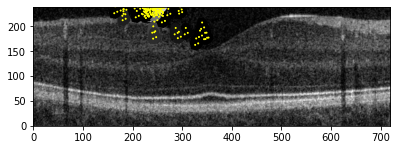

Worm width: 9.987167031372902


In [34]:
img = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
train(image=img, mu=30, lmbda=70)

Bruh